In [3]:
#Colab setting
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/DSAIL')

import os
os.chdir('/content/drive/My Drive/DSAIL')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Data U1.base로 train, u1.test로 test data만들기
# U.data는 현재 (["user_id", "movie_id", "rating", "timestamp"])로 구성
import pandas as pd
import torch

file_path = "ml-100k/u1.base"
columns = ["user_id", "movie_id", "rating", "timestamp"]
train_data = pd.read_csv(file_path, sep='\t', names=columns)
user_movie_matrix = train_data.pivot(index='user_id', columns='movie_id', values='rating')
train = user_movie_matrix.fillna(0).to_numpy(dtype=np.float32)

file_path = "ml-100k/u1.test"
columns = ["user_id", "movie_id", "rating", "timestamp"]
test_data = pd.read_csv(file_path, sep='\t', names=columns)
user_movie_matrix = test_data.pivot(index='user_id', columns='movie_id', values='rating')
test = user_movie_matrix.fillna(0).to_numpy(dtype=np.float32)


# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device", device)

#train = torch.tensor(train.values, dtype=torch.float32).to(device)
#test = torch.tensor(test.values, dtype=torch.float32).to(device)

device cuda


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class SVD(nn.Module):
  def __init__(self, train_R, test_R, d=50, learning_rate=1e-3, epochs=100, reg = 0.01, device=device):
    '''
    Typical SVD
    '''
    super(SVD, self).__init__()
    self.n, self.m = train_R.shape
    self.test_n, self.test_m = test_R.shape
    self.device = device
    self.latent_dimension = d
    self.train_R = train_R
    self.test_R = test_R
    self.lr = learning_rate
    self.epoch = epochs
    self.reg = reg
    self.criterion = nn.MSELoss()
    print("Number of User:", self.n)
    print("Number of Movies:", self.m)
    print("Shape of train_R:", self.train_R.shape)
    print("Shape of test_R:", self.test_R.shape)

    # parameters
    # self.P = (torch.rand(self.n, self.latent_dimension).to(self.device)) * (1.0 / self.latent_dimension) # (N, D)
    # self.Q = (torch.rand(self.m, self.latent_dimension).to(self.device)) * (1.0 / self.latent_dimension) # (M, D)

    # self.bu = (torch.rand(self.n).to(self.device))
    # self.bi = (torch.rand(self.m).to(self.device))
    # self.mu = torch.mean(train_R[train_R != 0]).item() # 0이 아닌 rating들의 평균
    self.P = np.random.rand(self.n, self.latent_dimension) * (1.0 / self.latent_dimension)  # (N, D)
    self.Q = np.random.rand(self.m, self.latent_dimension) * (1.0 / self.latent_dimension)  # (M, D)
    self.bu = np.random.rand(self.n)
    self.bi = np.random.rand(self.m)
    self.mu = np.mean(train_R[train_R != 0])


  def prediction(self, u, i):
    #return self.mu + self.bu[u] + self.bi[i] + self.P[u,:].matmul(self.Q[i,:].t()) #(1, D) dot (D, 1)
    return self.mu + self.bu[u] + self.bi[i] + np.dot(self.P[u, :], self.Q[i, :])

  def gradient(self, e, u, i):
    # Loss = (rating - prediction)^2  prediction + Reg = mu + bi + bu + PQT + reg(|P|^2 + |Q|^2 + bu^2 + bi^2)
    # dL/dbu = -2 * (rating - prediction)dp/dbu + 2*bu*reg = -2 * (rating - prediction) + 2*bu*reg
    dbu = -2 * e + 2 * (self.reg * self.bu[u])
    dbi = -2 * e + 2 * (self.reg * self.bi[i])
    # dL/dP = -2 * (rating - prediction)dp/dP + 2*P*reg= -2 * (rating - prediction) *(Q) + 2 *P* reg
    dP = -2 * (e * self.Q[i, :]) + 2 * (self.reg * self.P[u, :])
    dQ = -2 * (e * self.P[u, :]) + 2 * (self.reg * self.Q[i, :])

    return dbu, dbi, dP, dQ

  def gradeint_descent(self, u, i):
    e = self.train_R[u, i] - self.prediction(u, i)
    dbu, dbi, dP, dQ = self.gradient(e, u, i)
    self.bu[u] -=  self.lr * dbu
    self.bi[i] -=  self.lr * dbi
    self.P[u, :] -= self.lr * dP
    self.Q[i, :] -=  self.lr * dQ

  # def test_loss(self):
  #   test_loss = 0
  #   for uu in range(self.test_n):
  #     for ii in range(self.test_m):
  #       predicted_R = self.prediction(uu, ii)
  #       test_loss += (self.test_R[uu, ii] - predicted_R) ** 2
  #   test_loss =
  #   return test_loss

  def fit(self):
    train_loss_list = []
    test_loss_list = []


    for epoch in range(self.epoch):
      loss = 0
      test_loss = 0
      num_entries = 0
      num_test_entries = 0

      for u in range(self.n):
        for i in range(self.m):
          if self.train_R[u, i]:
            predicted_R = self.prediction(u, i)
            loss += (self.train_R[u, i] - predicted_R) ** 2
            num_entries += 1
            self.gradeint_descent(u, i)


      for uu in range(self.test_n):
        for ii in range(self.test_m):
          if self.test_R[uu, ii]: # test rmse
            predicted_R = self.prediction(uu, ii)
            test_loss += (self.test_R[uu, ii] - predicted_R) ** 2
            num_test_entries += 1

      rmse = np.sqrt(loss / num_entries)
      #test_rmse = self.test_loss
      test_rmse =np.sqrt(test_loss / num_test_entries)
      train_loss_list.append(rmse)
      test_loss_list.append(test_rmse)

      if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{self.epoch}], train_loss: {rmse}, test_loss: {test_rmse}')
    return train_loss_list, test_loss_list


Number of User: 943
Number of Movies: 1650
Shape of train_R: (943, 1650)
Shape of test_R: (459, 1410)
Epoch [0/100], train_loss: 1.3782327318341179, test_loss: 1.2998571034047466
Epoch [20/100], train_loss: 0.9386907197856363, test_loss: 1.0522119543777544
Epoch [40/100], train_loss: 0.9167623263545476, test_loss: 1.0513782239113538
Epoch [60/100], train_loss: 0.892378467947129, test_loss: 1.0518692704440449
Epoch [80/100], train_loss: 0.8552889060165316, test_loss: 1.0535356311136674


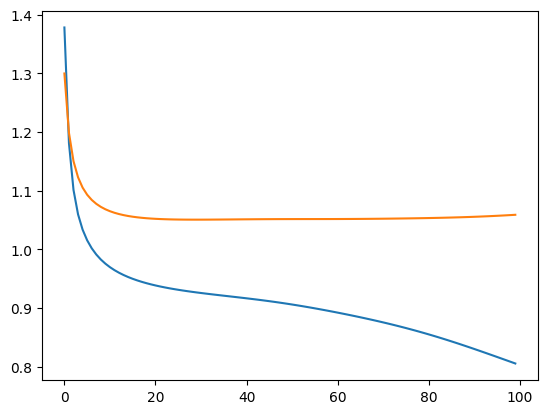

In [23]:
import matplotlib.pyplot as plt

model = SVD(train_R = train, test_R = test, d=15, epochs= 100)

# Train the model
train_loss_list, test_loss_list = model.fit()
train_loss_tensor = torch.tensor(train_loss_list, dtype=torch.float32)
plt.plot(train_loss_tensor.cpu().numpy())
test_loss_tensor = torch.tensor(test_loss_list, dtype=torch.float32)
plt.plot(test_loss_tensor.cpu().numpy())

Number of User: 943
Number of Movies: 1650
Shape of train_R: (943, 1650)
Shape of test_R: (459, 1410)
Epoch [0/100], train_loss: 1.4546293586080599, test_loss: 1.4262329876066062
Epoch [10/100], train_loss: 1.0233208780196081, test_loss: 1.1047505528097326
Epoch [20/100], train_loss: 0.9721717337017457, test_loss: 1.0684999381141
Epoch [30/100], train_loss: 0.9505881293548365, test_loss: 1.0572334131824266
Epoch [40/100], train_loss: 0.938474762220987, test_loss: 1.0530165612261118
Epoch [50/100], train_loss: 0.9305220479753179, test_loss: 1.0514626075521756
Epoch [60/100], train_loss: 0.9245526854482515, test_loss: 1.051010858233762
Epoch [70/100], train_loss: 0.9193877981873352, test_loss: 1.0509846534639626
Epoch [80/100], train_loss: 0.9142354698007358, test_loss: 1.0510471517449447
Epoch [90/100], train_loss: 0.9085183359393296, test_loss: 1.0510228127973775


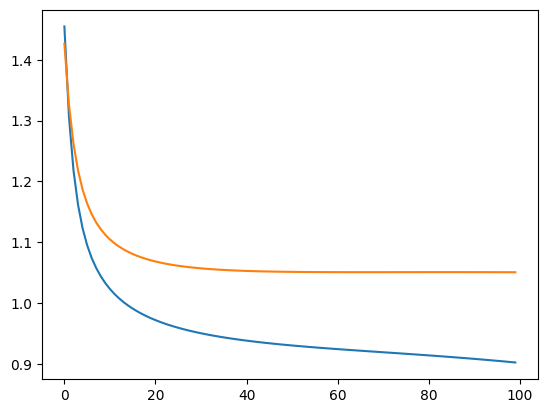

In [35]:
import matplotlib.pyplot as plt

model = SVD(train_R = train, test_R = test, d=10, learning_rate = 5e-4, epochs= 100)

# Train the model
train_loss_list, test_loss_list = model.fit()
train_loss_tensor = torch.tensor(train_loss_list, dtype=torch.float32)
plt.plot(train_loss_tensor.cpu().numpy())
test_loss_tensor = torch.tensor(test_loss_list, dtype=torch.float32)
plt.plot(test_loss_tensor.cpu().numpy())

# Pytorch VS Numpy
세상에 pytorch 연산보다 np.dot이 월등히 빠르다,,,,
